In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../.."))
from assets.modules.materials import ACIConcrete, BilinearSteel
from assets.modules.steel import LongitudinalRebar, TransverseRebar
from assets.modules.shapes import *
import assets.modules.concrete as concrete
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib.patches import bbox_artist


In [2]:
# Define axil load
Nu = 0 # lb

# Define material properties
C3 = ACIConcrete(fc=3000)
S60 = BilinearSteel("A706", fy=60000)

# Define reinforcement properties
R6 = LongitudinalRebar(size=6, mat=S60, is_skin_bar=False)
R10 = LongitudinalRebar(size=10, mat=S60, is_skin_bar=False)
T4 = TransverseRebar(size=4, mat=S60, nLegsX=2, nLegsY=2, spacing=6, is_looped=True)

# Define concrete cover
COVER = 2.0  # inch

# Define dimensions of a rectangular section
RECT_15X20 = Rectangle(width=15, height=20)

In [3]:
# Define concrete section with reinforcement
c_sec = concrete.RectangleReinforcedSection(shape=RECT_15X20, mat=C3, cover=COVER)

# Add transverse reinforcement
c_sec.add_trans_bar(T4)

# Add bottom longitudinal reinforcement
bottomBar = R10
p1 = Point(
    x = c_sec.shape.center.x, 
    y = - c_sec.shape.height/2 + COVER + c_sec.trans_bar_max_dia  + bottomBar.dia/2
)
c_sec.add_long_bar_row(bottomBar, center=p1, direction=(1,0), n=4)

# Add top longitudinal reinforcement
topBar = R6
p2 = Point(
    x = c_sec.shape.center.x, 
    y = c_sec.shape.height/2 - COVER - c_sec.trans_bar_max_dia - topBar.dia/2
)
c_sec.add_long_bar_row(topBar, center=p2, direction=(1,0), n=2)

# Print longitudinal bars
for bar in c_sec.long_bars:
    print(bar)

#10 long. rebar at Point(x=1.455, y=-6.865), fy=60000
#10 long. rebar at Point(x=-1.455, y=-6.865), fy=60000
#10 long. rebar at Point(x=4.365, y=-6.865), fy=60000
#10 long. rebar at Point(x=-4.365, y=-6.865), fy=60000
#6 long. rebar at Point(x=4.625, y=7.125), fy=60000
#6 long. rebar at Point(x=-4.625, y=7.125), fy=60000


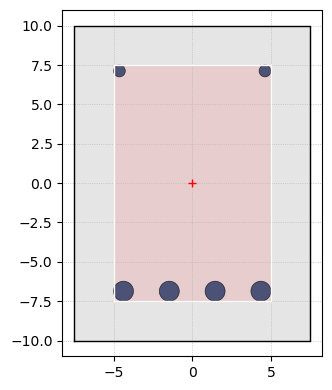

In [4]:
def plot_circle(circle: Circle, ax: matplotlib.axes.Axes = None, **kwargs) -> matplotlib.axes.Axes:        
    circle = plt.Circle(
        (circle.center.x, circle.center.y), 
        circle.radius,
        fill=False if kwargs.get('facecolor') is None else True,
        facecolor=kwargs.get('facecolor'), 
        edgecolor=kwargs.get('edgecolor'),
        linewidth=kwargs.get('linewidth'),
        alpha=kwargs.get('alpha'), 
        zorder=kwargs.get('zorder'),
    )
    ax.add_artist(circle)
    if kwargs.get('centeroid_color') is not None:
        ax.plot(circle.center.x, circle.center.y, marker='o', markersize=1, color=kwargs.get('centeroid_color'))
    ax.set_aspect('equal')
    return ax


def plot_rectangle(rect:Rectangle, ax: axes.Axes, show_centroid:bool=False, **kwargs):
    corners = rect.corners
    corners.append(corners[0]) # Add the first corner again to close the polygon
    corners = [(p.x, p.y) for p in corners] # Convert to tuples
    xs, ys = zip(*corners)
        
    ax.set_aspect('equal')
    ax.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=kwargs.get('ticksize'))
    ax.plot(xs, ys, color=kwargs.get('edgecolor', 'black'), linewidth=kwargs.get('linewidth', 1))
    if show_centroid:
        ax.plot(rect.center.x, rect.center.y, marker='+', color='red')
    ax.fill(xs, ys, color=kwargs.get('facecolor', 'grey'), alpha=kwargs.get('alpha', 0.2))
    ax.set_aspect('equal')
    return ax
    
    
    

fig, ax = plt.subplots(figsize=(5, 4))

ax = plot_rectangle(c_sec.shape, ax=ax, show_centroid=True)
ax = plot_rectangle(c_sec.core(), ax=ax, facecolor='red', edgecolor='white', alpha=0.1)
for bar in c_sec.long_bars:
    ax = plot_circle(bar.shape, ax=ax, facecolor='#0B1D51', edgecolor='black', linewidth=0.5, alpha=0.7)


plt.tight_layout()
plt.show()

In [5]:
def plot_section_strain(direction:str, y:list[np.ndarray], eps:list[np.ndarray], ax:axes.Axes, **kwargs):
    c = kwargs.get('c', ['#1B56FD', '#EB5B00'])
    lw = kwargs.get('lw', [2, 0.5])
    
    max_strain = max(eps[0].max(), eps[1].max())
    min_strain = min(eps[0].min(), eps[1].min())
    abs_max_strain = max(abs(min_strain), abs(max_strain))
    
    if direction in ['y', '-y']:
        x_val, y_val = y, eps
        ax.set_ylim(-1.25*abs_max_strain, 1.25*abs_max_strain)
        ax.set_ylabel('Strain (in/in)')
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    elif direction in ['x', '-x']:
        x_val, y_val = eps, y
        ax.set_xlim(-1.25*abs_max_strain, 1.25*abs_max_strain)
        ax.set_xlabel('Strain (in/in)')
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    else:
        raise ValueError("bending_direction must be 'x', '-x', 'y', or '-y'.")
        
    
    ax.plot(x_val[0], y_val[0], c=c[0], linewidth=lw[0], label='Concrete')
    ax.scatter(x_val[1], y_val[1], s=kwargs.get('s', 50), marker='o', c=c[1], edgecolor=kwargs.get('ec', 'black'), linewidth=lw[1], alpha=kwargs.get('alpha', 0.75), label='Rebar')
    
    ax.axhline(0, color='black', linewidth=0.5, linestyle='-')
    ax.axvline(0, color='black', linewidth=0.5, linestyle='-')

    ax.set_title('Strain Distribution', fontsize=10)
    ax.legend(fontsize=8, frameon=False)
    ax.grid(True, linestyle=':')
    
    return ax
    
    
def plot_section_stress(direction:str, y:list[np.ndarray], sigma:list[np.ndarray], ax:list[axes.Axes], **kwargs):
    c = kwargs.get('c', ['#1B56FD', '#EB5B00'])
    lw = kwargs.get('lw', [2, 0.5])
    
    if len(ax) != len(sigma):
        raise ValueError("Length of ax must match length of sigma.")
    
    # Convert stress from psi to ksi for plotting
    sigma = [s/1e3 for s in sigma]  # Convert psi to ksi
    
    if direction in ['y', '-y']:
        x_val, y_val = y, sigma
    elif direction in ['x', '-x']:
        x_val, y_val = sigma, y
    else:
        raise ValueError("bending_direction must be 'x', '-x', 'y', or '-y'.")
    
    ax[0].plot(x_val[0], y_val[0], c=c[0], linewidth=lw[0], label='Concrete')
    ax[0].set_title('Concrete Stress', fontsize=10)
    
    ax[1].scatter(x_val[1], y_val[1], s=kwargs.get('s', 50), c=c[1], edgecolor=kwargs.get('ec', 'black'), linewidth=lw[1], alpha=kwargs.get('alpha', 0.75), label='Rebar')
    ax[1].set_title('Rebar Stress', fontsize=10)
    
    for i in range(len(ax)):
        min_stress = sigma[i].min()
        max_stress = sigma[i].max()
        abs_max_stress = max(abs(min_stress), abs(max_stress))
        
        if direction in ['y', '-y']:
            ax[i].set_ylim(-1.25*abs_max_stress, 1.25*abs_max_stress)
            ax[i].set_ylabel('Stress (ksi)')
        elif direction in ['x', '-x']:
            ax[i].set_xlim(-1.25*abs_max_stress, 1.25*abs_max_stress)
            ax[i].set_xlabel('Stress (ksi)')
            
        ax[i].axhline(0, color='black', linewidth=0.5, linestyle='-')
        ax[i].axvline(0, color='black', linewidth=0.5, linestyle='-')
        ax[i].grid(True, linestyle=':')
    
    return ax
    
    
def plot_section_force(direction:str, y:list[np.ndarray], f:list[np.ndarray], ax:axes.Axes, **kwargs):
    c = kwargs.get('c', ['#1B56FD', '#EB5B00','#EB5B00'])

    f = [force / 1e3 for force in f]  # Convert force from lb to kips
    f_max = max(abs(value) for value in f if value is not None)
    
    arrowprops = {
        "head_width": 1,
        "length_includes_head": True,
    }

    if direction in ['y', '-y']:
        for i, (yi, fi) in enumerate(zip(y, f)):
            if direction == '-y':
                offset = -0.15 * yi if i==0 else 0.15 * yi
            else:
                offset = 0.15 * yi if i==0 else -0.15 * yi
                
            if yi is not None and fi is not None:
                ax.arrow(yi, 0, 0, fi, color=c[i], head_length=0.1*f_max, **arrowprops)
                ax.text(yi + offset, 0.5*fi, f"{fi:.0f} kips", fontsize=10, ha='center', va='center', rotation=90)
                
        ax.set_ylim(-1.25*f_max, 1.25*f_max)
        ax.set_ylabel('Normal Force (kips)')
        
    elif direction in ['x', '-x']:
        for i, (yi, fi) in enumerate(zip(y, f)):
            if direction == '-x':
                offset = 0.15 * yi if i==0 else -0.15 * yi
            else:
                offset = -0.15 * yi if i==0 else 0.15 * yi
                
            if yi is not None and fi is not None:
                ax.arrow(0, yi, fi, 0, color=c[i], head_length=0.1*f_max, **arrowprops)
                ax.text(0.5*fi, yi + offset, f"{fi:.0f} kips", color=c[i], fontsize=10, fontweight='bold', ha='center', va='center')
                
        ax.set_xlim(-1.25*f_max, 1.25*f_max)
        ax.set_xlabel('Normal Force (kips)')
    
    ax.axhline(0, color='black', linewidth=0.5, linestyle='-')
    ax.axvline(0, color='black', linewidth=0.5, linestyle='-')
    
    ax.set_title('Normal Force Distribution', fontsize=10)
    # ax.legend(fontsize=8, frameon=False)
    ax.grid(True, linestyle=':')
    
    return ax

In [6]:
D_NEUTR = 7.92278341958316 # in
B_DIR = '-x' # beam direction

beam = concrete.UniaixalBending(c_sec, bending_direction=B_DIR)

y_s = beam.get_long_bar_depth()
eps_s = beam.get_rebar_strain(D_NEUTR)
sigma_s = beam.get_rebar_stress(D_NEUTR)
f_s = beam.get_rebar_force(D_NEUTR)

y_c = beam.get_concrete_strip_depth()
eps_c = beam.get_concrete_strain(D_NEUTR)
sigma_c = beam.get_concrete_stress(D_NEUTR)
f_c = beam.get_concrete_force(D_NEUTR)



In [7]:
print(beam.get_tensile_effective_depth(D_NEUTR).round(3))
print(beam.get_compressive_effective_depth(D_NEUTR).round(3))

16.865
2.875


In [8]:
print(f"rebar strains:\n{beam.get_rebar_strain(D_NEUTR).round(5).flatten()}\n")
print(f"rebar stress (ksi):\n{beam.get_rebar_stress(D_NEUTR).round(0).flatten()}\n")
print(f"rebar force (kips):\n{beam.get_rebar_force(D_NEUTR).round(0).flatten()}\n")

rebar strains:
[ 0.00339  0.00339  0.00339  0.00339 -0.00191 -0.00191]

rebar stress (ksi):
[ 60000.  60000.  60000.  60000. -55430. -55430.]

rebar force (kips):
[ 76006.  76006.  76006.  76006. -24488. -24488.]



In [9]:
config = concrete.SolverConfig(
    method='secant',
    tolerance=1e-1,
    max_iterations=100,
    n_disc=1000,
)

beam.solve_neutral_depth_equilibrium(external_force=Nu, config=config)

{'neutral_depth': 7.92278341958316,
 'force': array([-507.16271986]),
 'moment': array([4129302.65213753])}

In [10]:
# p1 = beam.get_pure_flexure_point(external_force=Nu, tol=1e-1)
p2 = beam.get_tension_conrolled_point(external_force=Nu, n_disc=1000)
p3 = beam.get_balance_point(external_force=Nu, n_disc=1000)

print("Tension-Controlled Point:")
print(f"neutral depth: {p2['neutral_depth']:.3f} in")
print(f"force: {(p2['force'][0])/1e3:.0f} kips")
print(f"moment: {p2['moment'][0]/1e3/12:.0f} kip-in")
print()
print("Balance Point:")
print(f"neutral depth: {p3['neutral_depth']:.3f} in")
print(f"force: {(p3['force'][0])/1e3:.0f} kips")
print(f"moment: {p3['moment'][0]/1e3/12:.0f} kip-in")


Tension-Controlled Point:


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
# Compute total concrete force
f_ct = f_c.sum()

# Compute centroid of concrete forces
y_ct = np.sum(y_c * f_c) / f_ct if f_ct != 0 else None

# Compute total tensile rebar force
mask_st = f_s > 0
f_st = f_s[mask_st].sum()

# Compute centroid of tensile rebar forces
y_st = np.sum(y_s[mask_st] * f_s[mask_st]) / f_st if f_st != 0 else None

# Compute total compressive rebar force
mask_sc = f_s < 0
f_sc = f_s[mask_sc].sum()

# Compute centroid of compressive rebar forces
y_sc = np.sum(y_s[mask_sc] * f_s[mask_sc]) / f_sc if f_sc != 0 else None

print(f"Total concrete force: {f_ct/1e3:.2f} kips at {y_ct:.2f} in")
print(f"Total compressive rebar force: {f_sc/1e3:.2f} kips at {y_sc:.2f} in")
print(f"Total tensile rebar force: {f_st/1e3:.2f} kips at {y_st:.2f} in")

# The following should be close to zero to statisfy equilibrium
print(f"\nTotal normal force (f_ct + f_sc + f_st): {(f_ct + f_sc + f_st)/1e3:.2f} kips")

# Calculate location of resultant concrete compressive force from α=½ß1.c
# This should match y_ct obtained above
if B_DIR == '-x':
    c_force_depth = c_sec.shape.y_max - c_sec.mat.beta_1 * D_NEUTR/2
elif B_DIR == 'x':
    c_force_depth = c_sec.shape.y_min + c_sec.mat.beta_1 * D_NEUTR/2
elif B_DIR == '-y':
    c_force_depth = c_sec.shape.x_max - c_sec.mat.beta_1 * D_NEUTR/2
elif B_DIR == 'y':
    c_force_depth = c_sec.shape.x_min + c_sec.mat.beta_1 * D_NEUTR/2
else:
    raise ValueError("Bending direction must be '-x', 'x', '-y', or 'y'.")

print(f"\nDepth of concrete resultant compressive force: {c_force_depth:.2f} in")

# Calculate curvature at ultimate stage (ε_cu = 0.003) using the secant method
curvature = -c_sec.mat.eps_u / D_NEUTR

print(f"\nCurvature: {curvature:.2e} in/in")

Total concrete force: -257.85 kips at 6.60 in
Total compressive rebar force: -48.98 kips at 7.12 in
Total tensile rebar force: 304.02 kips at -6.87 in

Total normal force (f_ct + f_sc + f_st): -2.80 kips

Depth of concrete resultant compressive force: 6.63 in

Curvature: 3.79e-04 in/in


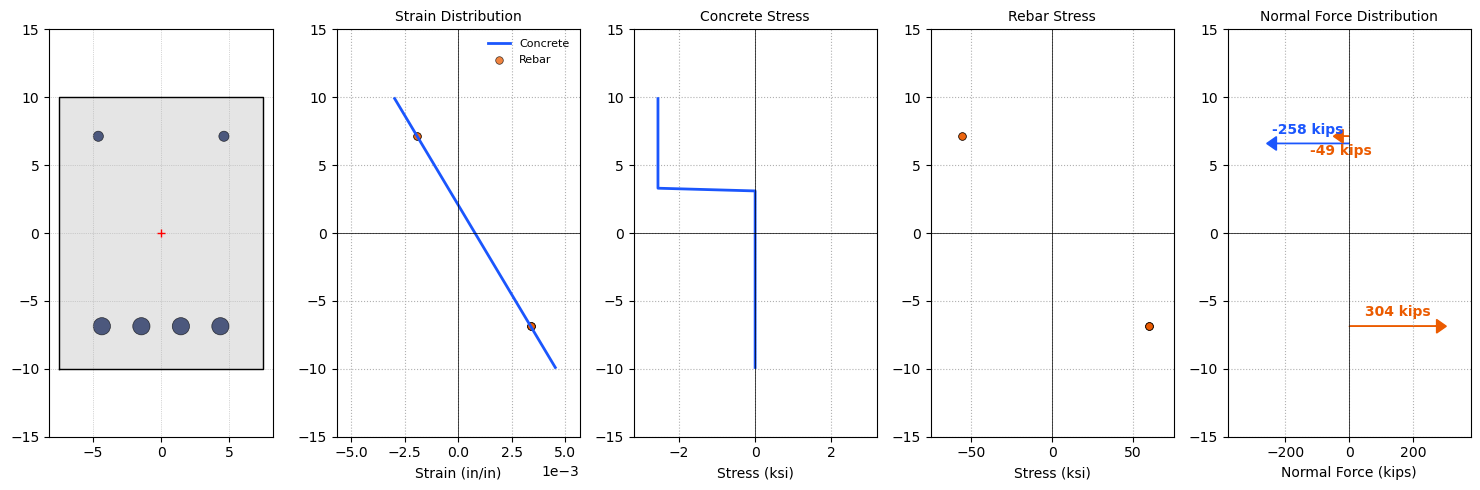

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))

ax[0] = plot_rectangle(c_sec.shape, ax=ax[0], bar_facecolor='black', show_centroid=True)
for bar in c_sec.long_bars:
    ax[0] = plot_circle(bar.shape, ax=ax[0], facecolor='#0B1D51', edgecolor='black', linewidth=0.5, alpha=0.7)
ax[1] = plot_section_strain(B_DIR, [y_c, y_s], [eps_c, eps_s], ax[1], s=30)
ax[2:4] = plot_section_stress(B_DIR, [y_c, y_s], [sigma_c, sigma_s], ax[2:4], s=30)
ax[4] = plot_section_force(B_DIR, [y_ct, y_sc, y_st], [f_ct, f_sc, f_st], ax=ax[4])


for a in ax:
    if B_DIR in ['y', '-y']:
        a.set_xlim(1.5*c_sec.shape.x_min, 1.5*c_sec.shape.x_max)
    elif B_DIR in ['x', '-x']:
        a.set_ylim(1.5*c_sec.shape.y_min, 1.5*c_sec.shape.y_max)

plt.tight_layout()
plt.show()

In [ ]:
# Find the tensile and compressive rebars based on the neutral depth and bending direction
tensile_rebars = beam.get_tensile_rebars(D_NEUTR)
compressive_rebars = beam.get_compressive_rebars(D_NEUTR)

# Compute the area of the tensile and compressive reinforcements
A_st = sum(bar.area for bar in tensile_rebars)
A_sc = sum(bar.area for bar in compressive_rebars)

# Effective depth for tensile and compressive reinforcements
d_st = beam.get_tensile_effective_depth(D_NEUTR)
d_sc = beam.get_compressive_effective_depth(D_NEUTR)

# Compute the ratio of the tensile and compressive reinforcements
rho_sc = A_sc / d_sc
rho_st = A_st / d_st

print(f"\nEffective depth for tensile reinforcement (d): {d_st:.2f} in")
print(f"Effective depth for compressive reinforcement (d'): {d_sc:.2f} in")
print(f"\nArea of tensile reinforcement (As): {A_st:.2f} in² [ρs: {rho_st:.2e}]")
print(f"Area of compressive reinforcement (A's): {A_sc:.2f} in² [ρ's: {rho_sc:.2e}]")

# Compute the area of the transverse reinforcement
A_v = beam.get_trans_bar_area()

print(f"\nArea of transverse reinforcement (Av): {A_v:.2f} in²")


Effective depth for tensile reinforcement (d): 16.87 in
Effective depth for compressive reinforcement (d'): 2.87 in

Area of tensile reinforcement (As): 5.07 in² [ρs: 3.00e-01]
Area of compressive reinforcement (A's): 0.88 in² [ρ's: 3.07e-01]

Area of transverse reinforcement (Av): 0.39 in²


In [ ]:
min_neutral_depth = 0.05 * beam.section_height()
max_neutral_depth = 0.95 * beam.section_height() # beam.get_xBar_depth()
neutral_depth_range = (min_neutral_depth, max_neutral_depth)

yn, f, m = concrete.generate_force_moment_interaction(
    beam, 
    
    neutral_depth_range=neutral_depth_range, 
    external_force=Nu, 
    n_points=1000
)

In [ ]:
m_scaled = np.divide(m, m.max())
f_scaled = np.divide(f, np.max(np.abs(f)))


P_cn = concrete.nominal_compressive_strength(beam.sec) # negative
P_cn_max = concrete.max_nominal_compressive_strength(beam.sec) # negative
P_tn = concrete.nominal_tensile_strength(beam.sec) # positive

balance_point = beam.get_balance_point(Nu, n_disc=1000)
tension_controlled_point = beam.get_tension_conrolled_point(Nu, n_disc=1000)
pure_flexure_point = beam.get_pure_flexure_point(Nu, config)


special_points = {
    'f': [
        P_cn / abs(P_cn),
        balance_point['force'][0] / abs(P_cn),
        tension_controlled_point['force'][0] / abs(P_cn),
        pure_flexure_point['force'][0] / abs(P_cn),
        P_tn / abs(P_cn)
    ],
    'm': [
        0.0,
        balance_point['moment'][0] / m.max(),
        tension_controlled_point['moment'][0] / m.max(),
        pure_flexure_point['moment'][0] / m.max(),
        0.0
    ]
}


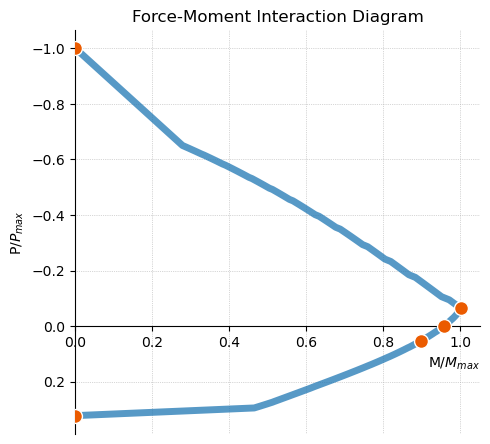

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(m_scaled, f_scaled, linewidth=5, alpha=0.75)
plt.scatter(special_points['m'], special_points['f'], color='#EB5B00', edgecolor='white', s=100, zorder=10)
plt.xlabel(r'M/$M_{max}$', loc='right')
plt.ylabel(r'P/$P_{max}$')
plt.title('Force-Moment Interaction Diagram')
plt.grid(True, linestyle=':', linewidth=0.5)
plt.gca().invert_yaxis()  # Reverse the y axis
plt.tight_layout()
# plt.axis('equal')
plt.xlim(left=0)
# Move the x-axis to y=0
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')

plt.show()

In [ ]:
# Compute the required minimum area of transverse reinforcement based on ACI 318-19 Section 9.6.3.4
def min_beam_transverse_rebar(bending: concrete.UniaixalBending) -> float:
    fc = bending.sec.mat.fc
    f_yt_min = min(bar.mat.fy for bar in bending.sec.trans_bars)
    bw = bending.section_width()
    return max(
        0.75 * np.sqrt(fc) * bw / f_yt_min ,
        50 * bw / f_yt_min
    )
    
A_v_min = min_beam_transverse_rebar(beam)

print(f"\nMinimum area of transverse reinforcement (Av,min): {A_v_min:.2e} in²")


Minimum area of transverse reinforcement (Av,min): 1.25e-02 in²


In [ ]:
# Compute the shear strength of concrete based on ACI 318-19 Section 22.5.5.1
def get_concrete_shear_strength(beam:concrete.UniaixalBending, axial_force:float, neutral_depth:float, is_normal_weight:bool=True) -> float:
    fc = beam.sec.mat.fc
    bw = beam.section_width()
    d = beam.get_tensile_effective_depth(neutral_depth)
    Ag = beam.sec.gross_area# in²
    Nu = axial_force
    
    tensile_rebars = beam.get_tensile_rebars(neutral_depth)
    A_st = sum(bar.area for bar in tensile_rebars)
    rho_st = A_st / d
    
    if is_normal_weight:
        lambda_ = 1.0
    else:
        lambda_ = 0.75
    
    V_c_max = 5 * lambda_ * np.sqrt(fc) * bw * d
    V_c_min = lambda_ * np.sqrt(fc) * bw * d
    print(f"V_c_max: {V_c_max:.0f} lb\nV_c_min: {V_c_min:.0f} lb")
    return min(
        max(
        (2 * lambda_ * np.sqrt(fc) + Nu / (6 * Ag)) * bw * d,
        ( 8 * lambda_ * rho_st**(1/3) * np.sqrt(fc) + Nu / (6 * Ag)) * bw * d,
        V_c_min
        ),
        V_c_max
    )
    
    
V_c = get_concrete_shear_strength(beam, axial_force=0, neutral_depth=D_NEUTR) / 1e3  # Convert to kips

print(f"\nShear strength of concrete (Vc): {V_c:.1f} kips")

V_c_max: 69280 lb
V_c_min: 13856 lb

Shear strength of concrete (Vc): 69.3 kips
